In [91]:
import open3d as o3d
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt

### ROOT DATA Location

In [2]:
DATA_ROOT = '../data/sets/v1.0-mini'

In [3]:
print("Load a ply point cloud, print it, and render it")
ply_point_cloud = o3d.data.PLYPointCloud()
pcd = o3d.io.read_point_cloud(ply_point_cloud.path)
print(pcd)
print(np.asarray(pcd.points))
o3d.visualization.draw_geometries([pcd],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

Load a ply point cloud, print it, and render it
PointCloud with 196133 points.
[[0.65234375 0.84686458 2.37890625]
 [0.65234375 0.83984375 2.38430572]
 [0.66737998 0.83984375 2.37890625]
 ...
 [2.00839925 2.39453125 1.88671875]
 [2.00390625 2.39488506 1.88671875]
 [2.00390625 2.39453125 1.88793314]]
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


### HELPER FUNCTIONS

In [4]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4459,
                                      front=[0.9288, -0.2951, -0.2242],
                                      lookat=[1.6784, 2.0612, 1.4451],
                                      up=[-0.3402, -0.9189, -0.1996])

### TEST FUNCTIONS

Test functions for the default PLY file, living room point cloud.

In [5]:
demo_icp_pcds = o3d.data.DemoICPPointClouds()
source = o3d.io.read_point_cloud(demo_icp_pcds.paths[0])
target = o3d.io.read_point_cloud(demo_icp_pcds.paths[1])
threshold = 0.02
trans_init = np.asarray([[0.862, 0.011, -0.507, 0.5],
                         [-0.139, 0.967, -0.215, 0.7],
                         [0.487, 0.255, 0.835, -1.4], [0.0, 0.0, 0.0, 1.0]])
draw_registration_result(source, target, trans_init)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [ ]:
print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(
    source, target, threshold, trans_init)
print(evaluation)

Initial alignment
RegistrationResult with fitness=1.747228e-01, inlier_rmse=1.177106e-02, and correspondence_set size of 34741
Access transformation to get result.


In [7]:
print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(source, target, reg_p2p.transformation)

Apply point-to-point ICP
RegistrationResult with fitness=3.724495e-01, inlier_rmse=7.760179e-03, and correspondence_set size of 74056
Access transformation to get result.
Transformation is:
[[ 0.83924644  0.01006041 -0.54390867  0.64639961]
 [-0.15102344  0.96521988 -0.21491604  0.75166079]
 [ 0.52191123  0.2616952   0.81146378 -1.50303533]
 [ 0.          0.          0.          1.        ]]
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [11]:
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=2000))
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(source, target, reg_p2p.transformation)

RegistrationResult with fitness=6.211230e-01, inlier_rmse=6.583448e-03, and correspondence_set size of 123501
Access transformation to get result.
Transformation is:
[[ 0.84024592  0.00687676 -0.54241281  0.6463702 ]
 [-0.14819104  0.96517833 -0.21706206  0.81180074]
 [ 0.52111439  0.26195134  0.81189372 -1.48346821]
 [ 0.          0.          0.          1.        ]]
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [12]:
print("Apply point-to-plane ICP")
reg_p2l = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPlane())
print(reg_p2l)
print("Transformation is:")
print(reg_p2l.transformation)
draw_registration_result(source, target, reg_p2l.transformation)

Apply point-to-plane ICP
RegistrationResult with fitness=6.209722e-01, inlier_rmse=6.581453e-03, and correspondence_set size of 123471
Access transformation to get result.
Transformation is:
[[ 0.84023324  0.00618369 -0.54244126  0.64720943]
 [-0.14752342  0.96523919 -0.21724508  0.81018928]
 [ 0.52132423  0.26174429  0.81182576 -1.48366001]
 [ 0.          0.          0.          1.        ]]
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


### NuScenes Data

Testing ICP on the Lidar Point Cloud data from the NuScenes dataset

In [25]:
import os
import struct

import numpy as np
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud
import open3d as o3d


nusc = NuScenes(version='v1.0-mini', dataroot=DATA_ROOT, verbose=True)


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.348 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


In [26]:
nusc.list_scenes()

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

In [27]:
my_scene = nusc.scene[0]
my_scene

{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

In [28]:
first_sample_token = my_scene['first_sample_token']

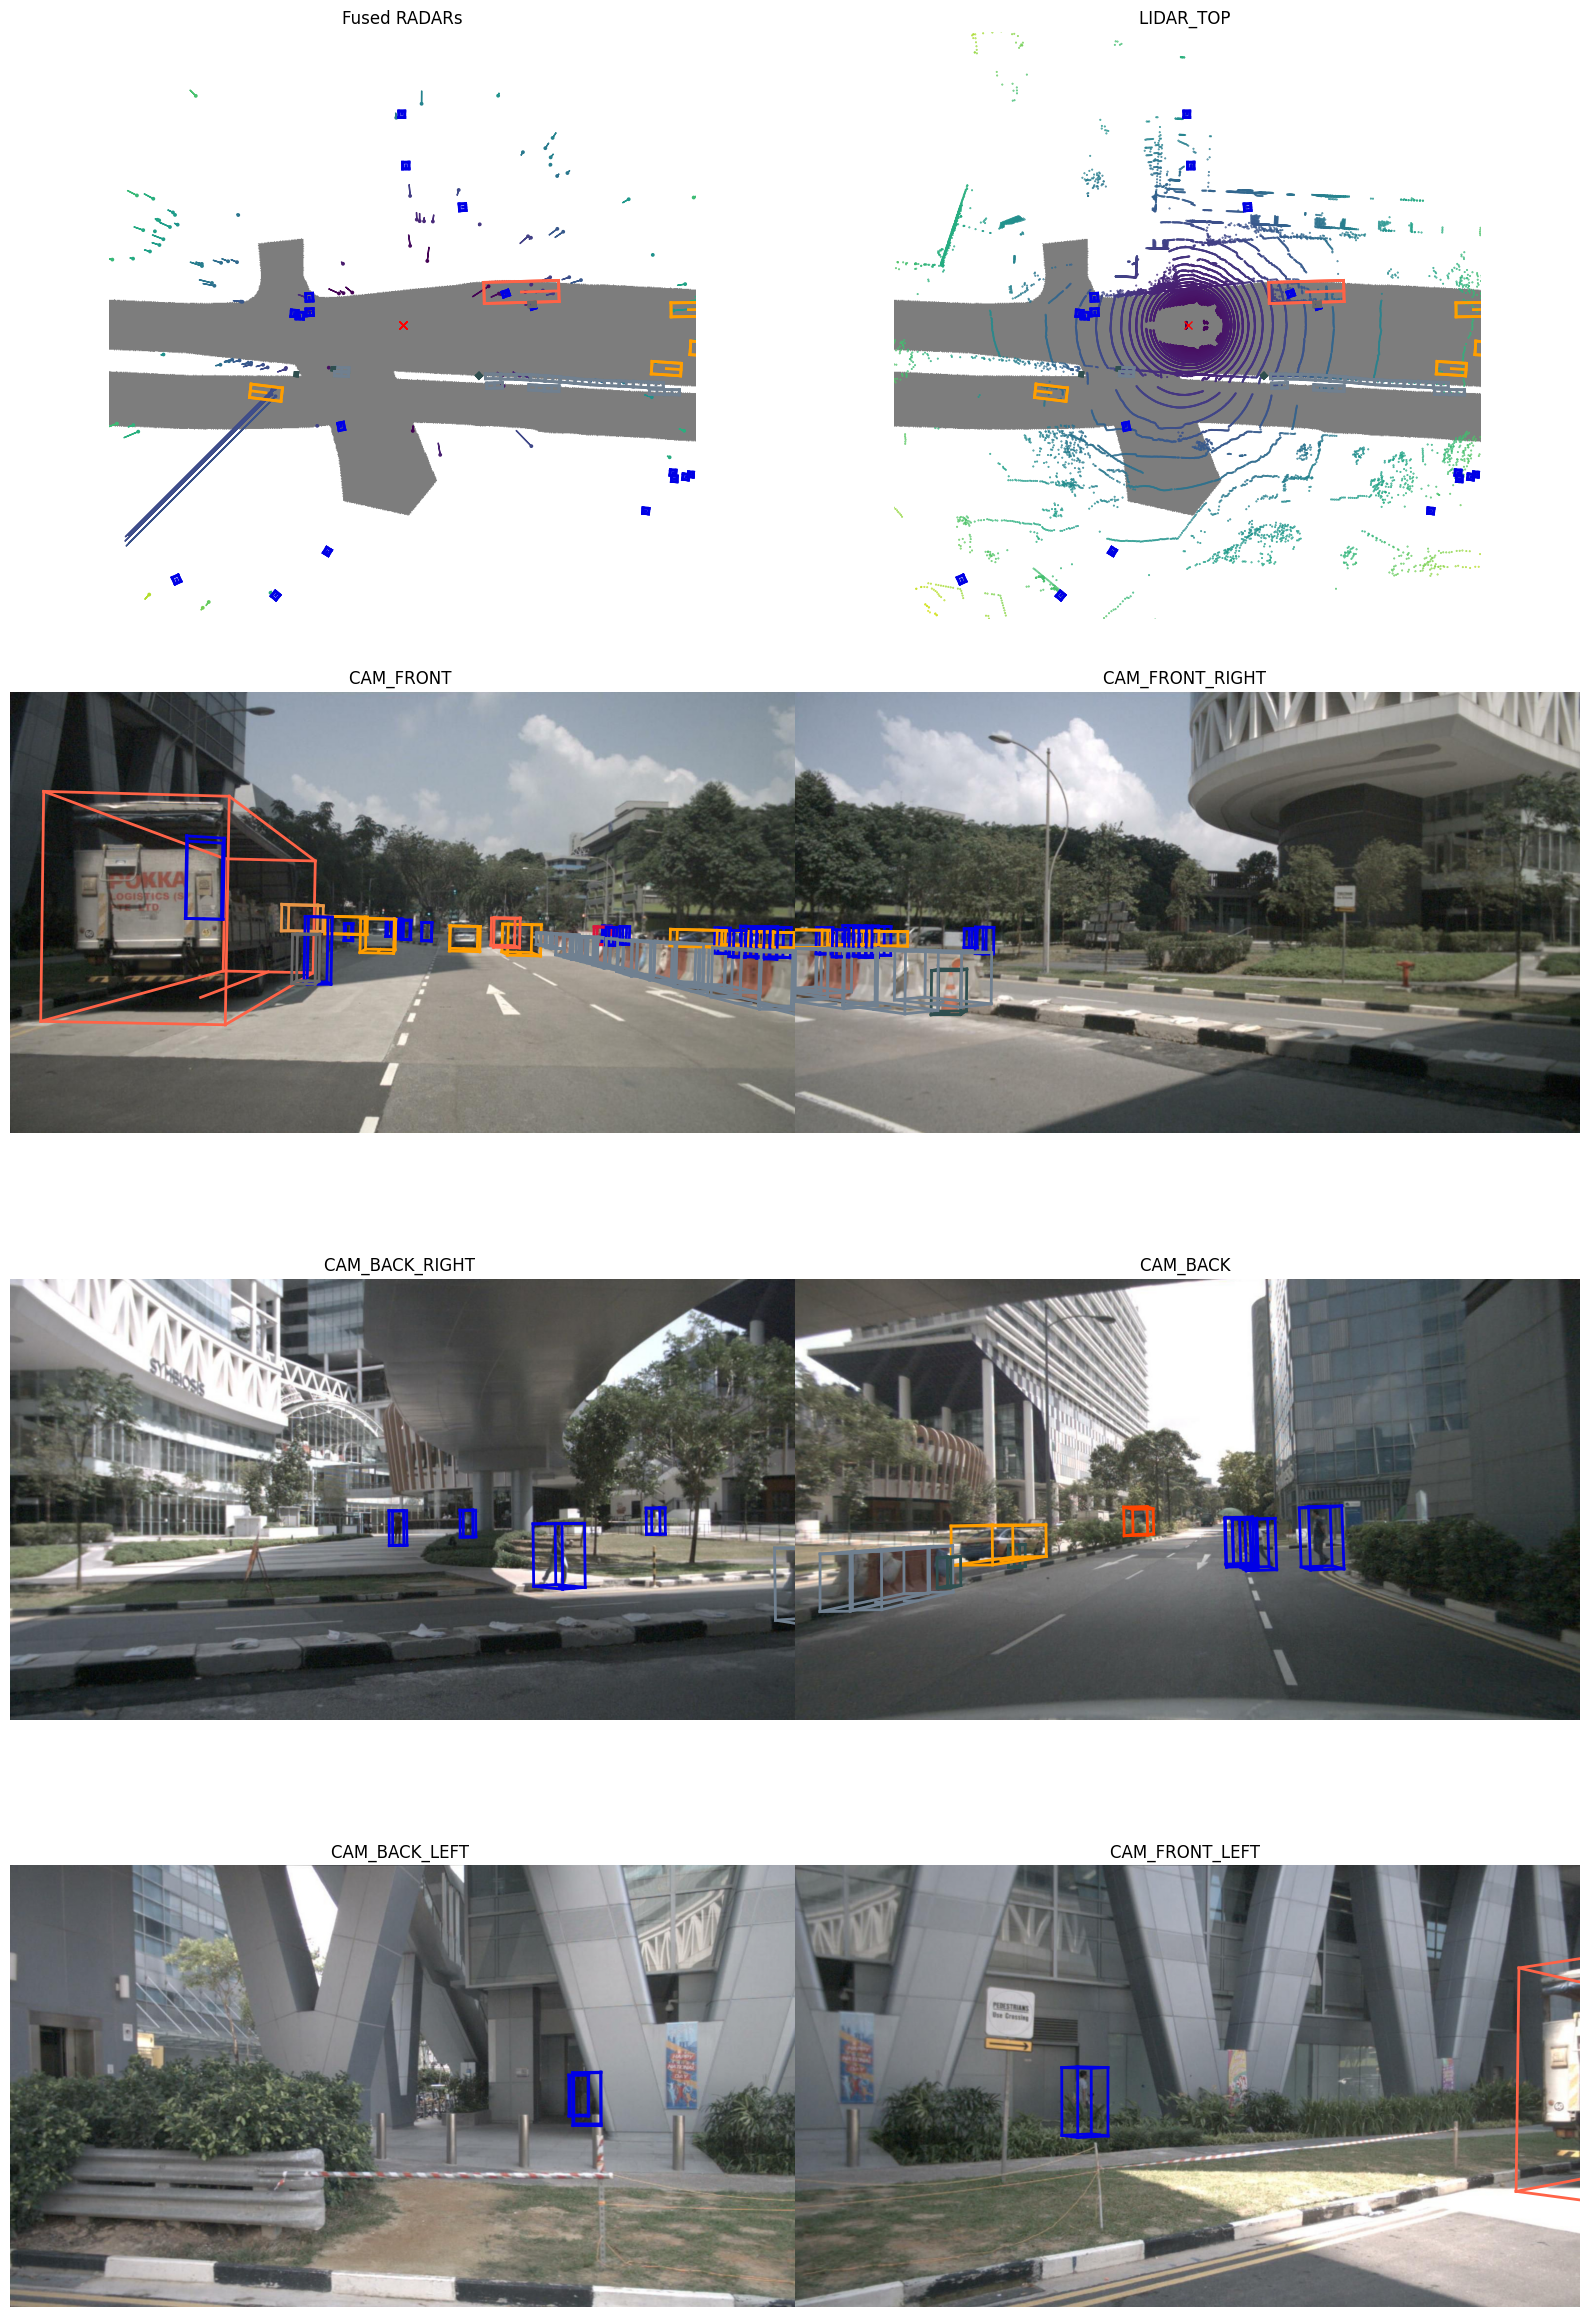

In [20]:
 nusc.render_sample(first_sample_token)

In [12]:
lt = nusc.get('sample', first_sample_token)
lt

{'token': 'ca9a282c9e77460f8360f564131a8af5',
 'timestamp': 1532402927647951,
 'prev': '',
 'next': '39586f9d59004284a7114a68825e8eec',
 'scene_token': 'cc8c0bf57f984915a77078b10eb33198',
 'data': {'RADAR_FRONT': '37091c75b9704e0daa829ba56dfa0906',
  'RADAR_FRONT_LEFT': '11946c1461d14016a322916157da3c7d',
  'RADAR_FRONT_RIGHT': '491209956ee3435a9ec173dad3aaf58b',
  'RADAR_BACK_LEFT': '312aa38d0e3e4f01b3124c523e6f9776',
  'RADAR_BACK_RIGHT': '07b30d5eb6104e79be58eadf94382bc1',
  'LIDAR_TOP': '9d9bf11fb0e144c8b446d54a8a00184f',
  'CAM_FRONT': 'e3d495d4ac534d54b321f50006683844',
  'CAM_FRONT_RIGHT': 'aac7867ebf4f446395d29fbd60b63b3b',
  'CAM_BACK_RIGHT': '79dbb4460a6b40f49f9c150cb118247e',
  'CAM_BACK': '03bea5763f0f4722933508d5999c5fd8',
  'CAM_BACK_LEFT': '43893a033f9c46d4a51b5e08a67a1eb7',
  'CAM_FRONT_LEFT': 'fe5422747a7d4268a4b07fc396707b23'},
 'anns': ['ef63a697930c4b20a6b9791f423351da',
  '6b89da9bf1f84fd6a5fbe1c3b236f809',
  '924ee6ac1fed440a9d9e3720aac635a0',
  '91e3608f55174a319

In [42]:
next_sample_token = lt['next']
lt1 = nusc.get('sample', next_sample_token)

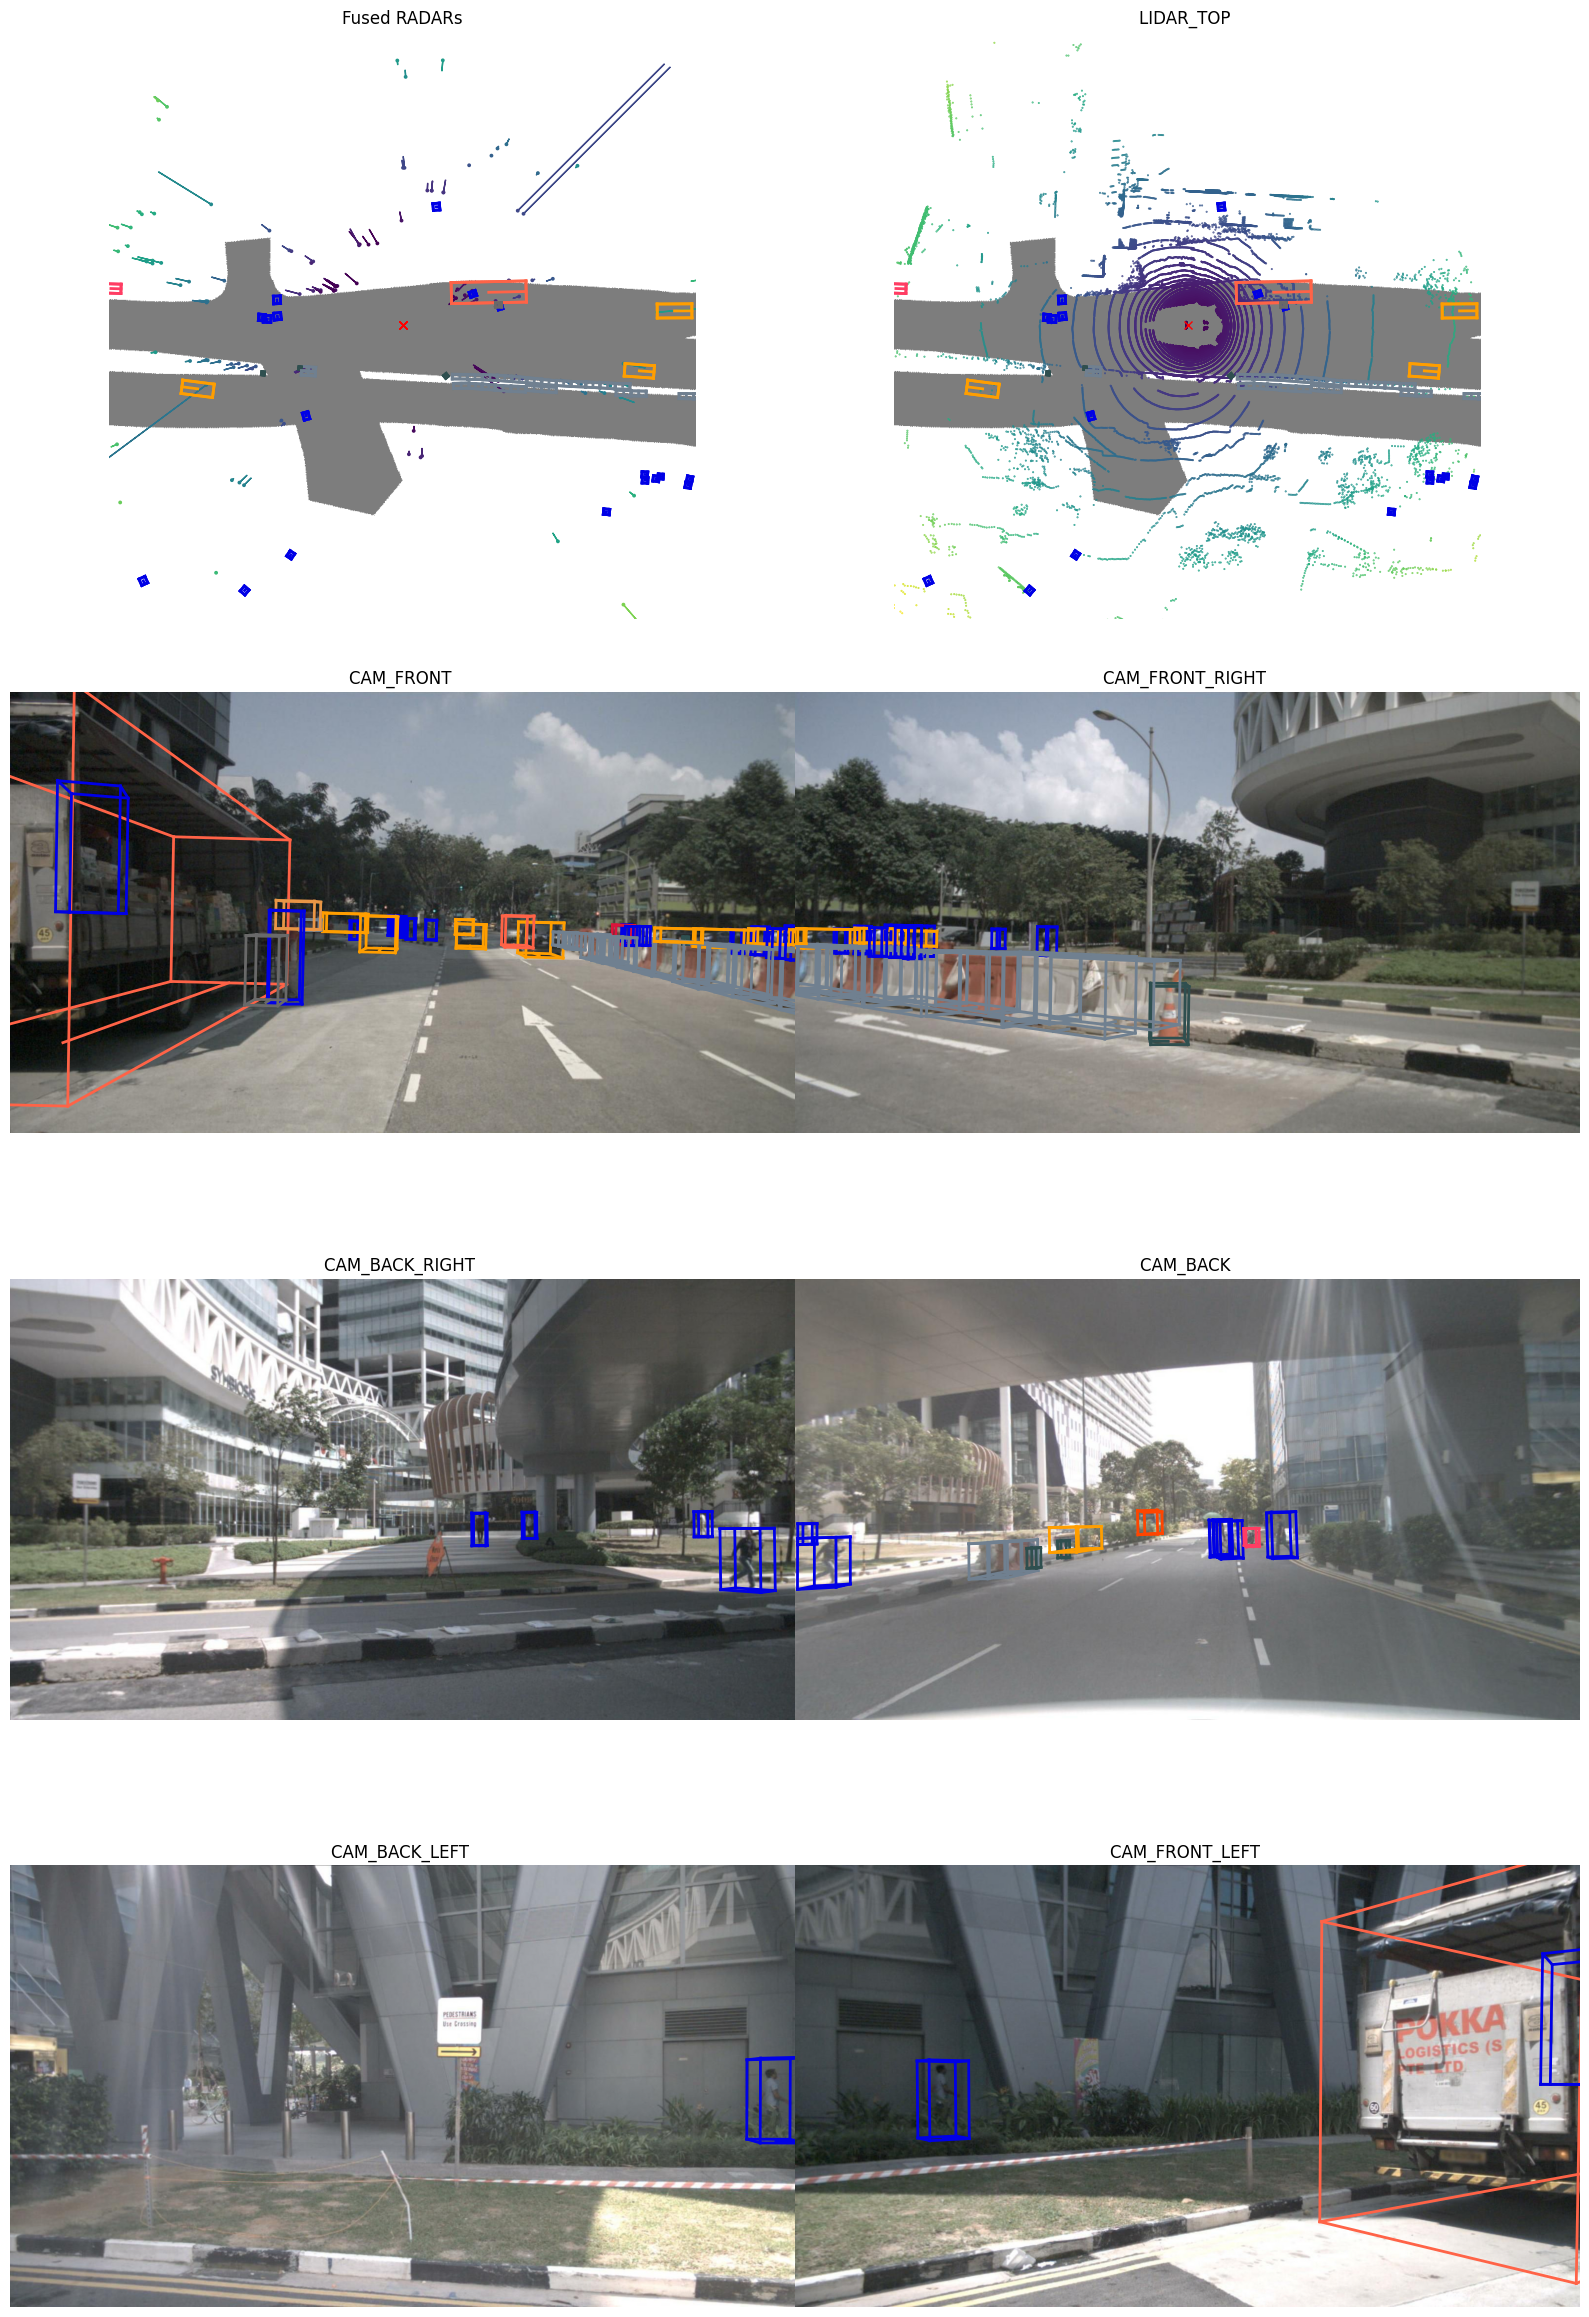

In [43]:
 nusc.render_sample(next_sample_token)

In [44]:
nusc.list_sample(lt['token'])

Sample: ca9a282c9e77460f8360f564131a8af5

sample_data_token: 37091c75b9704e0daa829ba56dfa0906, mod: radar, channel: RADAR_FRONT
sample_data_token: 11946c1461d14016a322916157da3c7d, mod: radar, channel: RADAR_FRONT_LEFT
sample_data_token: 491209956ee3435a9ec173dad3aaf58b, mod: radar, channel: RADAR_FRONT_RIGHT
sample_data_token: 312aa38d0e3e4f01b3124c523e6f9776, mod: radar, channel: RADAR_BACK_LEFT
sample_data_token: 07b30d5eb6104e79be58eadf94382bc1, mod: radar, channel: RADAR_BACK_RIGHT
sample_data_token: 9d9bf11fb0e144c8b446d54a8a00184f, mod: lidar, channel: LIDAR_TOP
sample_data_token: e3d495d4ac534d54b321f50006683844, mod: camera, channel: CAM_FRONT
sample_data_token: aac7867ebf4f446395d29fbd60b63b3b, mod: camera, channel: CAM_FRONT_RIGHT
sample_data_token: 79dbb4460a6b40f49f9c150cb118247e, mod: camera, channel: CAM_BACK_RIGHT
sample_data_token: 03bea5763f0f4722933508d5999c5fd8, mod: camera, channel: CAM_BACK
sample_data_token: 43893a033f9c46d4a51b5e08a67a1eb7, mod: camera, channel:

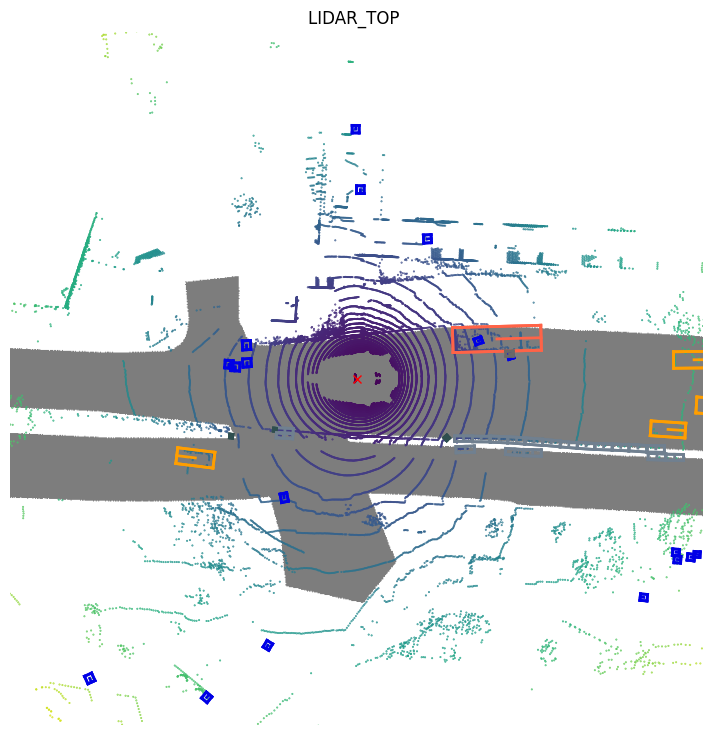

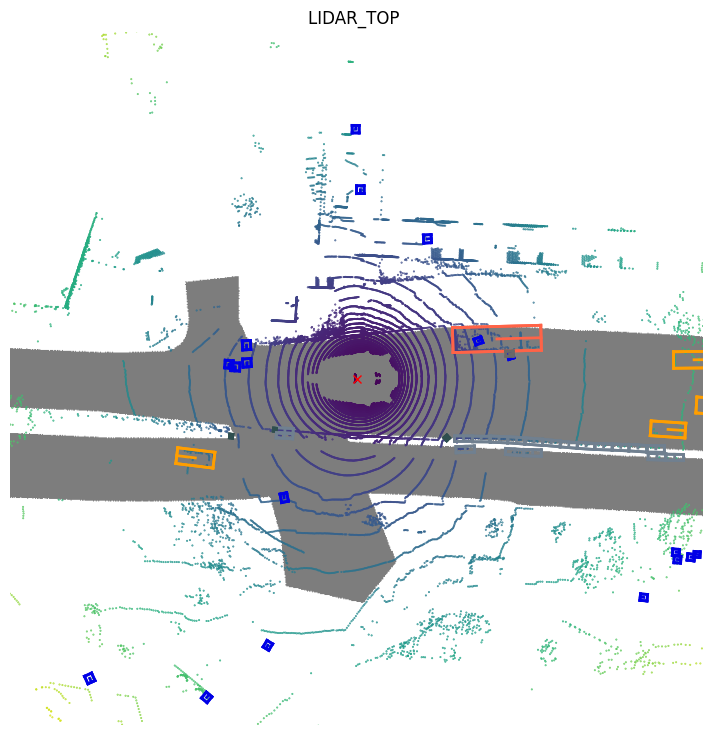

In [52]:
# Let's only look at the LIDAR DATA
lt_pc = nusc.get('sample_data', lt['data']['LIDAR_TOP'])
lt1_pc = nusc.get('sample_data', lt1['data']['LIDAR_TOP'])
nusc.render_sample_data(lt_pc['token'])
nusc.render_sample_data(lt_pc['token'])


In [92]:
def preprocess_lidar_data(lt_pc):
    os.path.join(DATA_ROOT, lt_pc['filename'])
    pc = LidarPointCloud.from_file(os.path.join(DATA_ROOT, lt_pc['filename']))
    source_bin_pcd = pc.points.T
    # Reshape and get only x, y, z coordinates.
    source_bin_pcd = source_bin_pcd.reshape((-1, 4))[:, 0:3]
    o3d_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(source_bin_pcd))
    return o3d_pcd

In [ ]:
# Visualize the point cloud using custom camera settings.
trans_init = np.asarray([[1, 0, 0, 0],
                         [0, 1, 0, 0],
                         [0, 0, 1, 0],
                        [0.0, 0.0, 0.0, 1.0]])

threshold = 0.02
source = preprocess_lidar_data(lt_pc)
target = preprocess_lidar_data(lt1_pc)

draw_registration_result(source, target, trans_init)


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [88]:
print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(
    source, target, threshold, trans_init)
print(evaluation)

Initial alignment
RegistrationResult with fitness=3.283845e-01, inlier_rmse=8.864226e-03, and correspondence_set size of 11391
Access transformation to get result.


In [87]:
source_downsampled = source.voxel_down_sample(voxel_size = 0.5)
target_downsampled = target.voxel_down_sample(voxel_size = 0.5)
print(len(source_downsampled.points), len(source.points))

6695 34688


In [86]:
draw_registration_result(source_downsampled, target_downsampled, trans_init)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [ ]:

reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=20000))
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)

RegistrationResult with fitness=3.449031e-01, inlier_rmse=8.170720e-03, and correspondence_set size of 11964
Access transformation to get result.
Transformation is:
[[ 9.99999839e-01 -5.53628830e-04 -1.26439397e-04  1.12960496e-03]
 [ 5.53688391e-04  9.99999736e-01  4.71511459e-04  1.08583757e-02]
 [ 1.26178321e-04 -4.71581391e-04  9.99999881e-01  4.58606785e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [60]:
draw_registration_result(source, target, reg_p2p.transformation)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [71]:
print("Apply point-to-plane ICP")
source.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=50))
target.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=50))

# Downsampling
reg_p2l = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPlane())
print(reg_p2l)
print("Transformation is:")
print(reg_p2l.transformation)

Apply point-to-plane ICP
RegistrationResult with fitness=8.443020e-02, inlier_rmse=1.416007e-02, and correspondence_set size of 1950
Access transformation to get result.
Transformation is:
[[ 9.99770612e-01 -2.14129713e-02 -4.55684750e-04 -4.70819432e-03]
 [ 2.14132108e-02  9.99770572e-01  5.27355929e-04  6.13812947e-03]
 [ 4.44287946e-04 -5.36992633e-04  9.99999757e-01  2.21993774e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [70]:
draw_registration_result(target, target, reg_p2l.transformation)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [75]:
o3d.visualization.draw_geometries([target],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [76]:
o3d.visualization.draw_geometries([source],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
